In [1]:
import datajoint as dj
from pipeline.utils.signal import spaced_max, longest_contiguous_block
from pipeline.utils.h5 import read_video_hdf5, ts2sec
from pipeline import experiment, notify
from pipeline.exceptions import PipelineException


import numpy as np
from commons import lab
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d


Connecting pfahey@10.28.3.113:3306
Loading local settings from pipeline_config.json


In [82]:
key = dict(animal_id = 15685, session = 2, scan_idx = 11)

In [83]:
#pull key info
rel = experiment.Session() * experiment.Scan.BehaviorFile().proj(hdf_file='filename')
info = (rel & key).fetch1()
print(info)

OrderedDict([('animal_id', 15685), ('session', 2), ('scan_idx', 11), ('rig', '2P4'), ('session_date', datetime.date(2017, 9, 27)), ('username', 'ecobost'), ('anesthesia', 'awake'), ('scan_path', 'R:\\Two-Photon\\jake\\2017-09-27_10-32-56'), ('behavior_path', 'R:\\Two-Photon\\jake\\2017-09-27_10-32-56'), ('craniotomy_notes', ' '), ('session_notes', ' '), ('archive', '2P4A1A'), ('session_ts', datetime.datetime(2017, 9, 27, 10, 32, 56)), ('hdf_file', '15685_2_00011_beh_%d.h5')])


In [84]:
#pull hdf_path
tmp = info['hdf_file'].split('.')
if not '%d' in tmp[0]:
    info['hdf_file'] = tmp[0][:-1] + '%d.' + tmp[-1]
print(info['hdf_file'])
hdf_path = lab.Paths().get_local_path("{behavior_path}/{hdf_file}".format(**info))
print(hdf_path)


15685_2_00011_beh_%d.h5
/mnt/scratch04/Two-Photon/jake/2017-09-27_10-32-56/15685_2_00011_beh_%d.h5


In [85]:
#read hdf5 file at hdf_path
data = read_video_hdf5(hdf_path)
print(data.keys())

dict_keys(['trialnum_ts', 'syncPd', 'analogPacketLen', 'ts', 'ball', 'scanImage', 'framenum_ts', 'eyecam_ts', 'version'])


In [86]:
packet_length = data['analogPacketLen']
print(packet_length)

2000.0


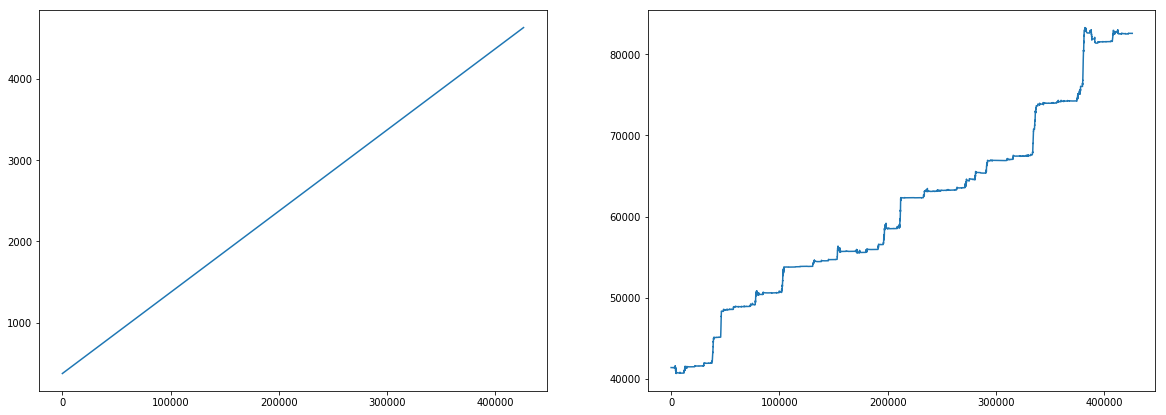

In [87]:
#read out counter time stamp and convert to seconds.  extract ball raw counts
ball_time,_ = ts2sec(data['ball'].transpose()[1],packet_length)
ball_raw = data['ball'].transpose()[0]

plt.subplot(1,2,1)
plt.plot(ball_time)
plt.subplot(1,2,2)
plt.plot(ball_raw)
plt.show()


In [88]:
#extract treadmill specs for session
diam, counts_per_revolution = (
experiment.TreadmillSpecs() * experiment.Session() & key & 'treadmill_start_date <= session_date').fetch('diameter', 'counts_per_revolution')
print(diam,counts)

if len(diam) != 1:
    raise PipelineException('Unclear which treadmill fits session key')

[ 20.32] [8000]


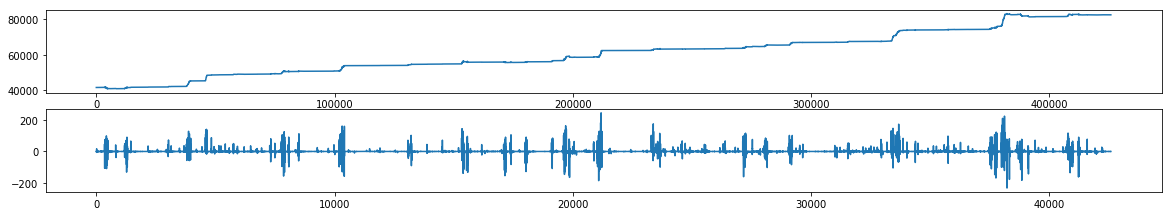

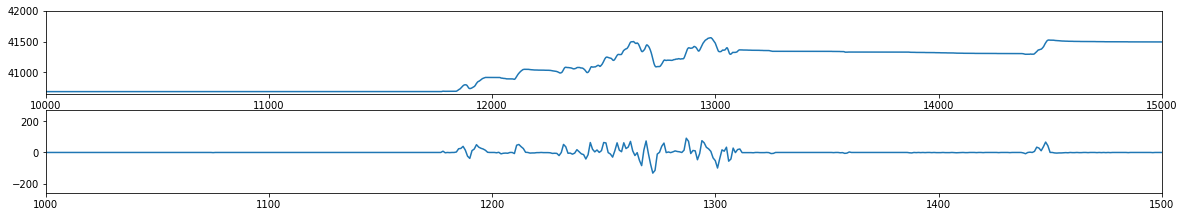

In [89]:
#extract ball counts and integrate in 100ms bins
ball_raw = data['ball'].transpose()[0]
ball_time_to_raw = interp1d(ball_time,ball_raw-ball_raw[0])
bin_times = np.arange(ball_time[0],ball_time[-1],.1)
bin_times[-1] = ball_time[-1]
ball_counts = np.append([0],np.diff(ball_time_to_raw(bin_times)))


ax3 = plt.subplot(4,1,1)
ax3.plot(ball_raw)
ax4 = plt.subplot(4,1,2)
ax4.plot(ball_counts)
plt.show()

plt.figure()
ax1 = plt.subplot(4,1,3)
ax1.plot(ball_raw)
ax1.set_xlim(10000,15000)
ax1.set_ylim(min(ball_raw),42000)
ax2 = plt.subplot(4,1,4)
ax2.plot(ball_counts)
ax2.set_xlim(1000,1500)
plt.show()

0.00797964534012


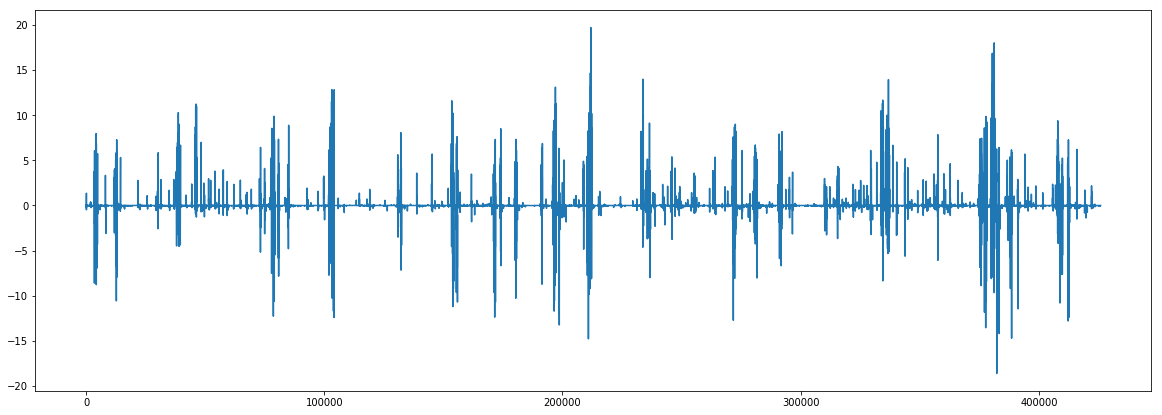

In [90]:
#convert counts to instantaneous (100ms bins) centimeters per second for each ball time
cmPerCount = np.pi*diam[-1]/counts_per_revolution[-1]
print(cmPerCount)
ball_time_to_vel = interp1d(bin_times, ball_counts*cmPerCount*10)
ball_vel = ball_time_to_vel(ball_time)
plt.plot(ball_vel)
plt.show()

In [91]:
key['treadmill_time'] = ball_time
key['treadmill_raw'] = ball_raw
key['treadmill_vel'] = ball_vel
print(key)

{'animal_id': 15685, 'treadmill_raw': array([ 41391.,  41391.,  41391., ...,  82587.,  82587.,  82587.]), 'scan_idx': 11, 'session': 2, 'treadmill_vel': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), 'treadmill_time': array([  374.170768 ,   374.1809217,   374.1907197, ...,  4633.2838597,
        4633.2951008,  4633.3040886])}
